In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
import io
from PIL import Image

from src.compound import Compound


def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

In [4]:
df = pd.read_csv('/home/rhjvanworkum/virtual_reactions/data/datasets/da/da_no_solvent_dataset.csv')
df

,Unnamed: 0,reaction_idx,uid,substrates,products,reaction_smiles,labels,simulation_idx
0,0,2,0,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O,COC(=O)C1(C)CC2C=C(Br)C1C(OC)(OC)C2=O,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O>>COC(=O)C...,0,0.0
1,1,2,1,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O,COC(=O)C1(C)CC2C(Br)=CC1C(=O)C2(OC)OC,C=C(C)C(=O)OC.COC1(OC)C=C(Br)C=CC1=O>>COC(=O)C...,1,0.0
2,2,6,2,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl,COC1(OC)C2(Cl)C(Cl)=C(Cl)C1(Cl)C1CC=CC12,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>COC1(...,1,0.0
3,3,6,3,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl,COC1(OC)C(Cl)=C(Cl)C2(Cl)C3C=CC(C3)C12Cl,C1=CCC=C1.COC1(OC)C(Cl)=C(Cl)C(Cl)=C1Cl>>COC1(...,0,0.0
4,4,7,4,C=CC(=O)CC.C=CC=CNC(=O)OCc1ccccc1,CCC(=O)C1CC=CC(NC(=O)OCc2ccccc2)C1,C=CC(=O)CC.C=CC=CNC(=O)OCc1ccccc1>>CCC(=O)C1CC...,0,0.0
...,...,...,...,...,...,...,...,...
1162,1162,1679,1162,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,C=CC1CC=CCC1(C(F)(F)F)C(F)(F)F,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>C=CC1CC=CCC1(...,0,0.0
1163,1163,1679,1163,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,FC(F)(F)C(=CC1CC=CCC1)C(F)(F)F,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>FC(F)(F)C(=CC...,1,0.0
1164,1164,1679,1164,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C,C=CC1CC=CC(C(F)(F)F)(C(F)(F)F)C1,C=CC=C(C(F)(F)F)C(F)(F)F.C=CC=C>>C=CC1CC=CC(C(...,0,0.0
1165,1165,1680,1165,O=C1C=CC(=O)C(Cl)=C1Cl.C1=CCC=C1,O=C1C=CC(=O)C2(Cl)C3C=CC(C3)C12Cl,O=C1C=CC(=O)C(Cl)=C1Cl.C1=CCC=C1>>O=C1C=CC(=O)...,0,0.0


1


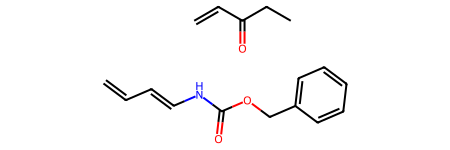

In [5]:
idx = 5
print(df['labels'].values[idx])
Chem.MolFromSmiles(df['substrates'].values[idx])

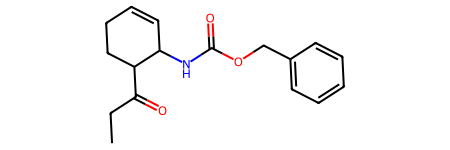

In [6]:
Chem.MolFromSmiles(df['products'].values[idx])

In [7]:
def normalize_idxs(idxs):
    scaler = StandardScaler()
    scaler.fit(idxs)
    idxs = scaler.transform(idxs)
    return 100 * idxs

def generate_fukui_plot(smiles, id):
    mol = Compound.from_smiles(smiles)
    mol.generate_conformers()
    mol.optimize_conformers()
    idxs = mol.compute_fukui_indices()
    
    new_idxs = np.array([i[id] for i in idxs]).reshape(-1, 1)
    new_idxs = normalize_idxs(new_idxs).flatten().tolist()

    d = Draw.MolDraw2DCairo(400, 400)
    SimilarityMaps.GetSimilarityMapFromWeights(Chem.AddHs(Chem.MolFromSmiles(smiles)), new_idxs, draw2d=d)
    d.FinishDrawing()
    return show_png(d.GetDrawingText())

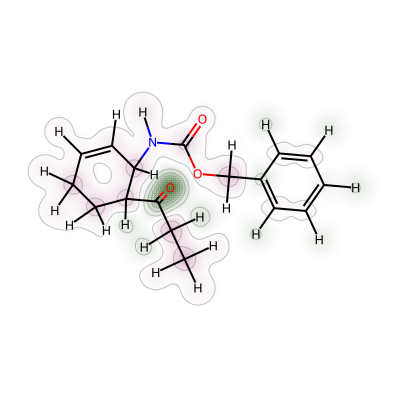

In [10]:
p = generate_fukui_plot(df['products'].values[idx], 1)
p

In [16]:
da_mol_pattern = Chem.MolFromSmiles("C1=CCCCC1")

def get_sum_square_diff(smiles: str):
    mol = Compound.from_smiles(smiles)
    mol.generate_conformers()
    mol.optimize_conformers()
    idxs = mol.compute_fukui_indices()
    
    elec_idxs = np.array([idx[0] for idx in idxs])
    nuc_idxs = np.array([idx[1] for idx in idxs])
    
    react_atom_idxs = mol.rdkit_mol.GetSubstructMatch(da_mol_pattern)
    
    diff = 0
    for atom_idx in react_atom_idxs:
        diff += (nuc_idxs[atom_idx] - elec_idxs[atom_idx])**2
    return diff

get_sum_square_diff(df['products'].values[0])

0.005193034999999998

In [17]:
get_sum_square_diff(df['products'].values[1])

0.005180902500000002

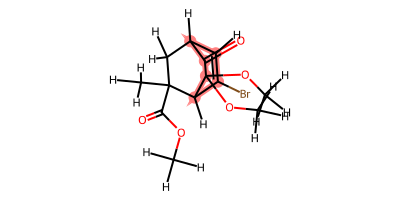

In [21]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG


smiles = df['products'].values[0]
mol = Compound.from_smiles(smiles)

drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol.rdkit_mol,highlightAtoms=mol.rdkit_mol.GetSubstructMatch(da_mol_pattern))
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

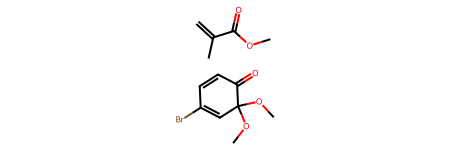

In [23]:
Chem.MolFromSmiles(df['substrates'].values[0])